In [5]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.cluster.hierarchy import dendrogram

In [9]:
df = pd.read_csv('../data/vendors_cleaned.csv', index_col=[0])

In [10]:
df.head()


,id,vendor_category_id,delivery_charge,serving_distance,vendor_rating,prepration_time,discount_percentage,American,Arabic,Asian,...,Smoothies,Soups,Spanish Latte,Steaks,Sushi,Sweets,Thai,Thali,Vegetarian,Waffles
0,4,2.0,0.0,6.0,4.4,15,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13,2.0,0.7,5.0,4.7,14,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20,2.0,0.0,8.0,4.5,19,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23,2.0,0.0,5.0,4.5,16,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28,2.0,0.7,15.0,4.4,10,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## K-means clustering
### chosing k using 'elbow test'

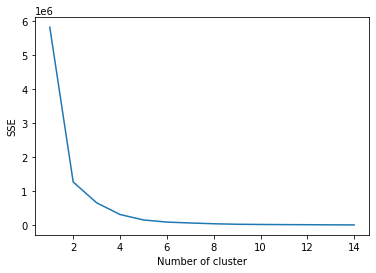

In [11]:
# data-structure to store Sum-Of-Square-Errors
sse = {}
# Looping over multiple values of k from 1 to 15
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100).fit(df)
    df["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
# Plotting the curve with 'k'-value vs SSE
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.savefig('elbow_method.png')

Sharp drop of sum of squares error was achieved with k=6

In [12]:
best_k = 6
kmeans = KMeans(n_clusters=best_k, init='k-means++', max_iter=100).fit(df)
df["clusters"] = kmeans.labels_

In [13]:
df['clusters'].value_counts()

3    29
1    27
4    17
0    11
2     9
5     7
Name: clusters, dtype: int64

<AxesSubplot:>

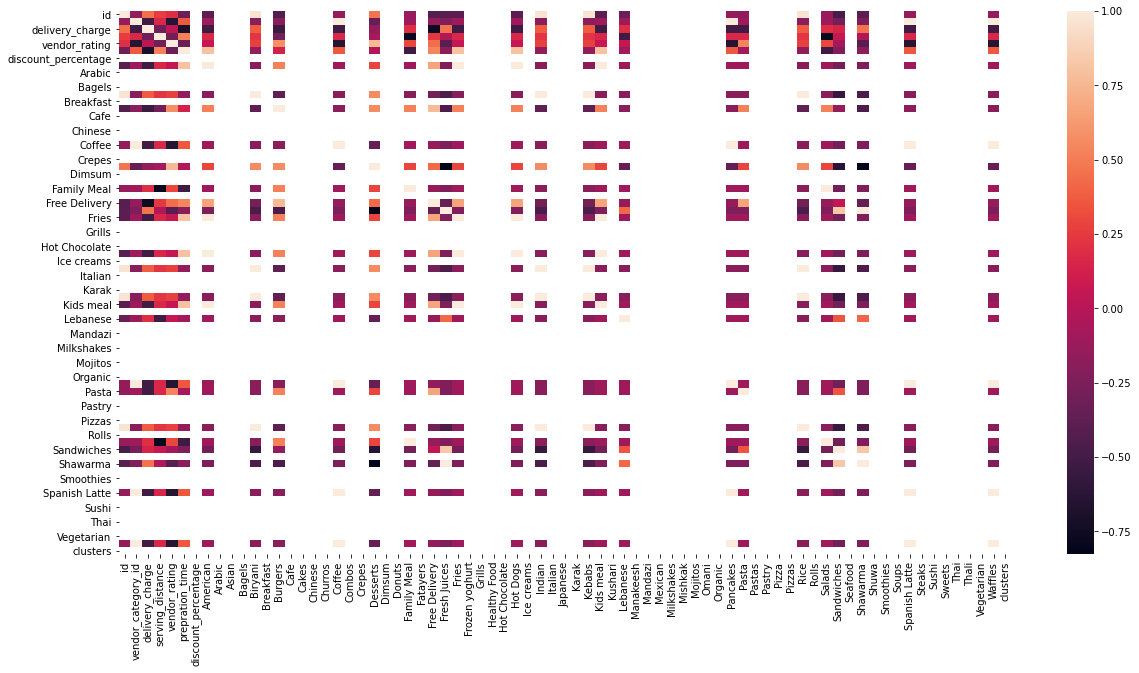

In [14]:
plt.figure(figsize=(20,10))
sns.heatmap(df.loc[df['clusters'] == 0].corr())

In [15]:
df.loc[df['clusters'] == 0].describe()


,id,vendor_category_id,delivery_charge,serving_distance,vendor_rating,prepration_time,discount_percentage,American,Arabic,Asian,...,Soups,Spanish Latte,Steaks,Sushi,Sweets,Thai,Thali,Vegetarian,Waffles,clusters
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0,11.000000,11.0,11.0,...,11.0,11.000000,11.0,11.0,11.0,11.0,11.0,11.0,11.000000,11.0
mean,598.909091,2.090909,0.509091,13.818182,4.372727,10.909091,0.0,0.090909,0.0,0.0,...,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0
std,53.219272,0.301511,0.326970,2.442056,0.142063,3.753786,0.0,0.301511,0.0,0.0,...,0.0,0.301511,0.0,0.0,0.0,0.0,0.0,0.0,0.301511,0.0
min,537.000000,2.000000,0.000000,8.000000,4.100000,5.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
25%,574.000000,2.000000,0.350000,14.500000,4.300000,10.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
50%,578.000000,2.000000,0.700000,15.000000,4.400000,10.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
75%,629.500000,2.000000,0.700000,15.000000,4.450000,10.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
max,681.000000,3.000000,0.700000,15.000000,4.600000,20.000000,0.0,1.000000,0.0,0.0,...,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0


## Aglomerative clustering
Using ward measure as linkage criterion, euclidean distance as metric used to compute linkage

In [16]:
agglo_clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(df)
df['agglomerative'] = agglo_clustering.labels_

In [17]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(20,10))
    dendrogram(linkage_matrix, **kwargs)
    plt.savefig('dendogram.png')

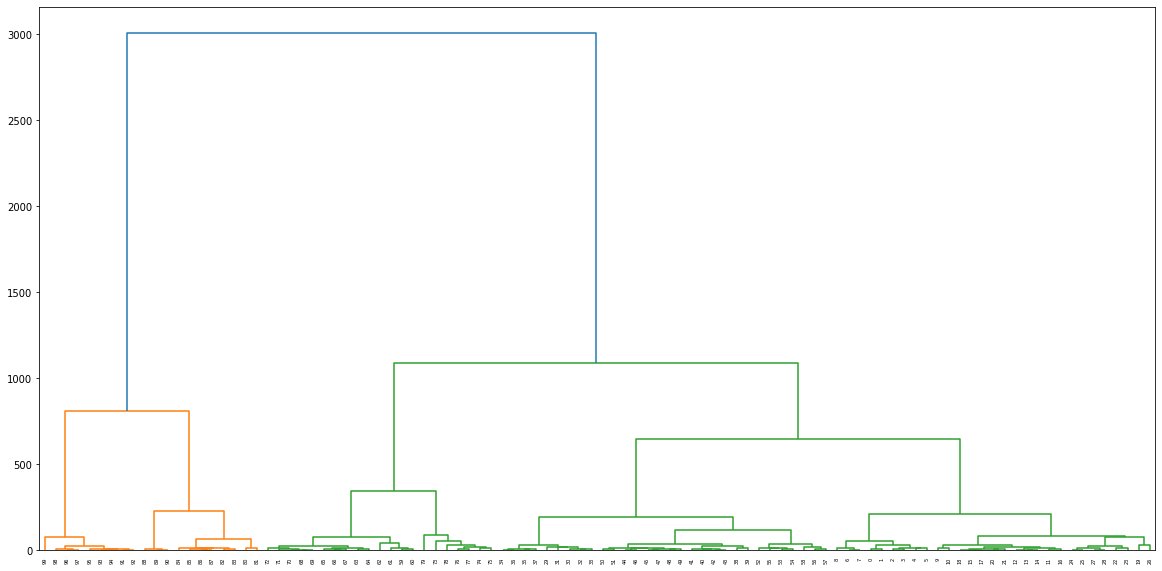

In [18]:
plot_dendrogram(agglo_clustering)

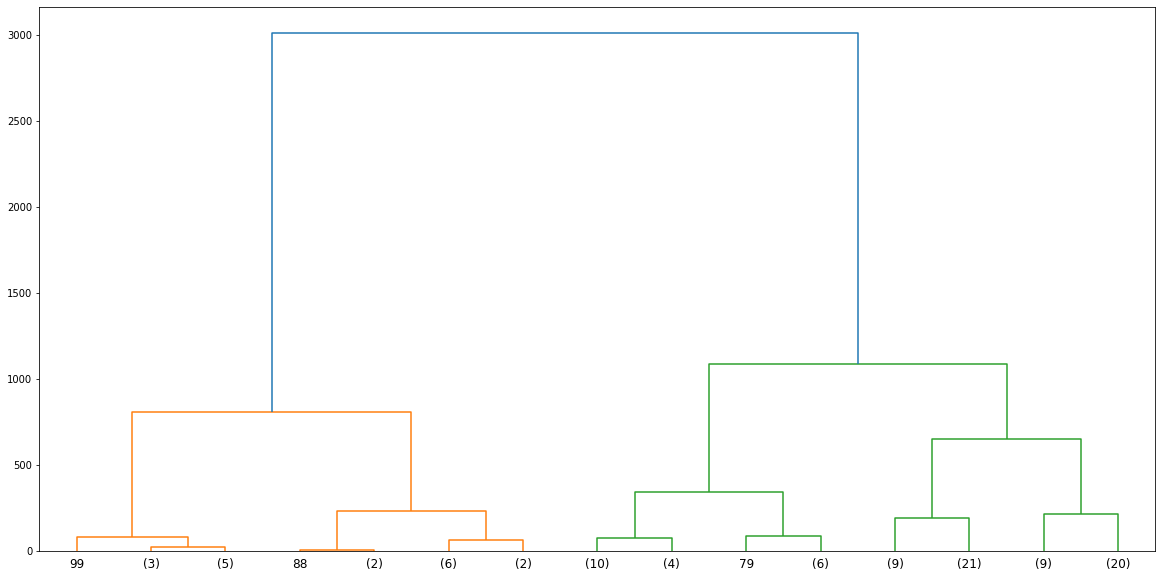

In [19]:
plot_dendrogram(agglo_clustering, truncate_mode='level', p=3)

In [20]:
agglo_clustering = AgglomerativeClustering(n_clusters=7).fit(df)
df['agglomerative'] = agglo_clustering.labels_

In [21]:
df['agglomerative'].value_counts()

2    29
1    17
6    15
4    12
0    11
3     9
5     7
Name: agglomerative, dtype: int64

In [22]:
def predict_top_n_items_for_item_id(item_id: int, n: int, model: str):
    item_id_row = df.loc[df['id'] == item_id]
    
    if model == "Kmeans":
        cluster_id = item_id_row['clusters'].to_numpy()[0]
        items_with_cluster_id = df.loc[df['clusters'] == cluster_id]
    elif model == "Agglomerative":
        cluster_id = item_id_row['agglomerative'].to_numpy()[0]
        items_with_cluster_id = df.loc[df['agglomerative'] == cluster_id]
    similarities = {}
    for id, item in items_with_cluster_id.iterrows():
        similarities[item['id']] = cosine_similarity(item_id_row.to_numpy().reshape(1, -1), item.to_numpy().reshape(1, -1))
    similarities_sorted = {k: v for k, v in sorted(similarities.items(), key=lambda item: item[1], reverse=True)[1:n+1]}
    result = {k: v.reshape(1,)[0] for k, v in similarities_sorted.items()}
    return result
    

In [23]:
list_predicted_kmeans = predict_top_n_items_for_item_id(13, n=15, model="Kmeans")

In [24]:
predicted_ids = list_predicted_kmeans.keys()
print(predicted_ids)
df.loc[df['id'].isin(predicted_ids)]


dict_keys([20.0, 23.0, 33.0, 4.0, 43.0, 28.0, 55.0, 44.0, 66.0, 67.0, 78.0, 76.0, 79.0, 81.0, 83.0])


,id,vendor_category_id,delivery_charge,serving_distance,vendor_rating,prepration_time,discount_percentage,American,Arabic,Asian,...,Spanish Latte,Steaks,Sushi,Sweets,Thai,Thali,Vegetarian,Waffles,clusters,agglomerative
0,4,2.0,0.0,6.0,4.4,15,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
2,20,2.0,0.0,8.0,4.5,19,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
3,23,2.0,0.0,5.0,4.5,16,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
4,28,2.0,0.7,15.0,4.4,10,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
5,33,2.0,0.7,6.0,4.6,17,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
6,43,2.0,0.7,15.0,4.3,15,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
7,44,2.0,0.7,15.0,4.3,14,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
8,55,2.0,0.7,10.0,4.5,19,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
9,66,2.0,0.0,15.0,4.0,20,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
10,67,2.0,0.0,15.0,4.3,15,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2


In [25]:
list_predicted_aglo = predict_top_n_items_for_item_id(13, n=15, model="Agglomerative")

In [26]:
predicted_ids = list_predicted_aglo.keys()
print(predicted_ids)
df.loc[df['id'].isin(predicted_ids)]


dict_keys([20.0, 23.0, 33.0, 4.0, 43.0, 28.0, 55.0, 44.0, 66.0, 67.0, 78.0, 76.0, 79.0, 81.0, 83.0])


,id,vendor_category_id,delivery_charge,serving_distance,vendor_rating,prepration_time,discount_percentage,American,Arabic,Asian,...,Spanish Latte,Steaks,Sushi,Sweets,Thai,Thali,Vegetarian,Waffles,clusters,agglomerative
0,4,2.0,0.0,6.0,4.4,15,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
2,20,2.0,0.0,8.0,4.5,19,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
3,23,2.0,0.0,5.0,4.5,16,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
4,28,2.0,0.7,15.0,4.4,10,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
5,33,2.0,0.7,6.0,4.6,17,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
6,43,2.0,0.7,15.0,4.3,15,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
7,44,2.0,0.7,15.0,4.3,14,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
8,55,2.0,0.7,10.0,4.5,19,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
9,66,2.0,0.0,15.0,4.0,20,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
10,67,2.0,0.0,15.0,4.3,15,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2


In [28]:
test_user_orders = pd.read_csv('../data/test_user_orders.csv')

In [55]:
from typing import List, Tuple

def validate_recommendations(method: str, N: int, user_ids: List[int]) -> Tuple[int, int]:
    precision_at_N = []
    recall_at_N = []
    average_precisions_at_N =[]
    
    for user_id in user_ids:
        vendor_list = test_user_orders.loc[test_user_orders['customer_id'] == user_id]['vendor_id'].to_list()
        half = int(len(vendor_list) / 2) + 1
        train_vendors = vendor_list[:half]
        test_vendors = vendor_list[half:]
        
        all_recommended_vendors = []
        for vendor in train_vendors:
            predicted = predict_top_n_items_for_item_id(vendor, N, method)
            predicted = [[k, v] for k, v in predicted.items()]
            all_recommended_vendors.extend(predicted)
        # print(all_recommended_vendors)
        all_rec_filtered = [[id, sim] for [id, sim] in all_recommended_vendors if id not in train_vendors]
        all_rec_filtered.sort(key=lambda x: x[1], reverse=True)
        all_rec_unique = [item for n, item in enumerate(all_rec_filtered) if item[0] not in [i[0] for i in all_rec_filtered[:n]]][:N]
        all_rec_unique_ids = [item[0] for item in all_rec_unique]
        
        
        relevant_reccomendations = list(set(test_vendors).intersection(all_rec_unique_ids))
        n_relevant = len(relevant_reccomendations)
        n_recommended = len(all_rec_unique)
        
        is_relevant = [1 if x in relevant_reccomendations else 0 for x in all_rec_unique_ids]
    
        sums_at_n = [sum(is_relevant[:n]) for n in range(len(is_relevant))]
        precisions_at_n = [x/(i+1) for i, x in enumerate(sums_at_n)]
        
        average_precision = sum(precisions_at_n) * (1/ len(precisions_at_n))
        
        precision = n_relevant / n_recommended
        recall = n_relevant/ (100 - len(train_vendors))
            
        average_precisions_at_N.append(average_precision)
        precision_at_N.append(precision)
        recall_at_N.append(recall)
    
    
    # print(precision_at_N)
    # print(recall_at_N)
    f_p = sum(precision_at_N) / len(precision_at_N)
    f_r = sum(recall_at_N) / len(recall_at_N)
    map = sum(average_precisions_at_N) / len(average_precisions_at_N)
    
    print(f'Precision at {N}: {round(f_p, 3)}')
    print(f'Recall at {N}: {round(f_r, 3)}')
    print(f'Average precision at {N}: {round(map, 4)}')
    return f_p, f_r, map
    

In [29]:
test_user_ids = test_user_orders['customer_id'].unique().tolist()

In [56]:
validate_recommendations('Kmeans', 10, test_user_ids)


Precision at 10: 0.01
Recall at 10: 0.001
Average precision at 10: 0.0021


(0.01, 0.0010638297872340426, 0.0021111111111111113)

In [57]:

validate_recommendations('Agglomerative', 10, test_user_ids)

Precision at 10: 0.01
Recall at 10: 0.001
Average precision at 10: 0.0021


(0.01, 0.0010638297872340426, 0.0021111111111111113)